In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd "/gdrive/MyDrive/capstone_project/"

Mounted at /gdrive
/gdrive/MyDrive/capstone_project


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime as dt

In [3]:
df = pd.read_csv("합천_댐기상종합데이터.csv")
df.index = pd.to_datetime(df["시간"])
df = df.drop(["시간"], axis=1)
df['홍수기'] = 0
df.loc[(df.index.month >= 6) & (df.index.month <= 9) & (df.index.day >= 21) & (df.index.day <= 20), '홍수기'] = 1

In [4]:
df_date = df.assign(month = df.index.month).assign(day_of_week = df.index.dayofweek).assign(week_of_year = df.index.week)

<ipython-input-4-cc327fcf453a>:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_date = df.assign(month = df.index.month).assign(day_of_week = df.index.dayofweek).assign(week_of_year = df.index.week)


In [5]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

df_date = generate_cyclical_features(df_date, 'day_of_week', 7, 0)
df_date = generate_cyclical_features(df_date, 'month', 12, 1)
df_date = generate_cyclical_features(df_date, 'week_of_year', 52, 0)

df_date.head()

,전일유입량,저수량(현재),전일방류량(본댐),저수량차이,2일전유입량,3일전유입량,4일전유입량,5일전유입량,6일전유입량,7일전유입량,...,1일후평균강수량(mm),2일후평균강수량(mm),3일후평균강수량(mm),홍수기,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year
시간,,,,,,,,,,,,,,,,,,,,,
2000-01-01,7.4,513.4,28.9,173.4,5.8,3.5,5.5,6.9,5.0,5.3,...,0.000000,0.000000,0.000000,0,-0.974928,-0.222521,0.0,1.0,6.432491e-16,1.000000
2000-01-02,4.4,512.1,23.7,173.0,7.4,5.8,3.5,5.5,6.9,5.0,...,0.000000,0.000000,0.187500,0,-0.781831,0.623490,0.0,1.0,6.432491e-16,1.000000
2000-01-03,4.7,509.8,26.1,171.8,4.4,7.4,5.8,3.5,5.5,6.9,...,0.000000,0.187500,1.020833,0,0.000000,1.000000,0.0,1.0,1.205367e-01,0.992709
2000-01-04,3.8,508.4,27.3,171.4,4.7,4.4,7.4,5.8,3.5,5.5,...,0.187500,1.020833,0.135417,0,0.781831,0.623490,0.0,1.0,1.205367e-01,0.992709
2000-01-05,6.1,506.5,25.2,170.4,3.8,4.7,4.4,7.4,5.8,3.5,...,1.020833,0.135417,0.000000,0,0.974928,-0.222521,0.0,1.0,1.205367e-01,0.992709


In [6]:
df_date = df_date[['전일유입량', '저수량(현재)', '평균기온(°C)', '평균습도(%)', '전일방류량(본댐)', '평균강수량(mm)', '홍수기', 'sin_day_of_week', 'cos_day_of_week', 'sin_month', 'cos_month', 'sin_week_of_year', 'cos_week_of_year', '당일유입량', '1일후유입량', '2일후유입량']]

In [7]:
# 열의 순서를 조정하기 위해 열의 리스트 생성
columns = list(df_date.columns)

# '당일유입량', '1일후유입량', '2일후유입량' 열(Column)을 맨 뒤로 이동
#columns += ['당일유입량', '1일후유입량', '2일후유입량']
columns = [col for col in columns if col not in ['당일유입량', '1일후유입량', '2일후유입량']]

# 열 순서 조정한 DataFrame 생성
df_date = df_date[columns + ['당일유입량', '1일후유입량', '2일후유입량']]
df_date.columns

Index(['전일유입량', '저수량(현재)', '평균기온(°C)', '평균습도(%)', '전일방류량(본댐)', '평균강수량(mm)',
       '홍수기', 'sin_day_of_week', 'cos_day_of_week', 'sin_month', 'cos_month',
       'sin_week_of_year', 'cos_week_of_year', '당일유입량', '1일후유입량', '2일후유입량'],
      dtype='object')

In [8]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_date)

In [9]:
df_scaled = pd.DataFrame(data=scaled_data, columns=df_date.columns, index=df_date.index.values)
df_scaled.head()

,전일유입량,저수량(현재),평균기온(°C),평균습도(%),전일방류량(본댐),평균강수량(mm),홍수기,sin_day_of_week,cos_day_of_week,sin_month,cos_month,sin_week_of_year,cos_week_of_year,당일유입량,1일후유입량,2일후유입량
2000-01-01,0.003900,0.582187,0.347890,0.553127,0.017042,0.000000,0.0,0.000000,0.356896,0.5,1.0,0.500000,1.000000,0.002319,0.002477,0.002003
2000-01-02,0.002319,0.580059,0.421855,0.576004,0.013976,0.000000,0.0,0.099031,0.801938,0.5,1.0,0.500000,1.000000,0.002477,0.002003,0.003215
2000-01-03,0.002477,0.576293,0.302154,0.462633,0.015391,0.000000,0.0,0.500000,1.000000,0.5,1.0,0.560268,0.996354,0.002003,0.003215,0.004217
2000-01-04,0.002003,0.574001,0.273040,0.474835,0.016099,0.000000,0.0,0.900969,0.801938,0.5,1.0,0.560268,0.996354,0.003215,0.004217,0.003373
2000-01-05,0.003215,0.570891,0.345530,0.546518,0.014860,0.005805,0.0,1.000000,0.356896,0.5,1.0,0.560268,0.996354,0.004217,0.003373,0.003110


In [10]:
train = df_scaled.loc["2000-02-02":"2018-12-31"]
test = df_scaled.loc["2019-01-01":]

In [11]:
train_scaled = train.values
test_scaled = test.values

## Train

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [13]:
# 훈련 데이터셋에 대해 X와 y를 분리하고 3일 단위로 묶기
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence)):
        # 인덱스를 기준으로 입력 시퀀스와 출력 시퀀스를 나누기
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix, :-3], sequence[end_ix:out_end_ix, -3]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 훈련 및 테스트 데이터셋 생성
n_steps_in = 7
n_steps_out = 3
X_train, y_train = split_sequence(train_scaled, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test_scaled, n_steps_in, n_steps_out)

## 모델

In [14]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GRU, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Layer==2

In [15]:
learning_rate = 0.0001

In [20]:
units = [64, 128, 256, 512, 1024]
dropouts = [0, 0.2, 0.4, 0.6, 0.8]
epochs = [100, 500, 1000]

In [ ]:
timesteps = 7
for u in units:
  for d in dropouts:
    for e in epochs:
      print("======================================================================================")
      print(f"units: {u}, dropout: {d}, epoch: {e}")
      model = Sequential()
      model.add(GRU(u, input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
      model.add(Dropout(d))
      
      model.add(GRU(int(u/2)))
      model.add(Dropout(d))
      
      model.add(Dense(3))
      model.compile(optimizer="adam", loss="mse")
      model.fit(X_train, y_train, epochs=e, batch_size=96, verbose=0)
      
      y_pred = model.predict(X_test)
      y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])

      #RMSE
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      print('RMSE:', rmse, end="\t")
      #MAE
      mae = mean_absolute_error(y_test, y_pred)
      print('MAE:', mae, end="\t")
      #MSE
      mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
      print("MSE:", mse, end="\t")

      # PBIAS 계산
      diff = np.sum(y_pred - y_test)
      sum_observed = np.sum(y_test)
      pbias = (diff / sum_observed) * 100
      print('PBIAS:', pbias, end="\t")

      # NSE 계산
      diff_pred_obs = np.sum((y_pred - y_test) ** 2)
      diff_obs_mean = np.sum((y_test - np.mean(y_test)) ** 2)
      nse = 1 - (diff_pred_obs / diff_obs_mean)
      print('NSE:', nse, end="\t")
      print()

      mae = np.mean(np.abs(y_test - y_pred), axis=0)
      mse = np.mean(np.square(y_test - y_pred), axis=0)
      plt.figure(figsize=(10, 6))
      plt.plot(mae, label="MAE")
      plt.plot(mse, label="MSE")
      plt.xlabel("Time Step")
      plt.ylabel("Error")
      plt.legend()
      plt.savefig(f"images/1_units_{u} dropout_{d} epoch_{e}.png")
      plt.close()

      plt.figure(figsize=(16, 8))
      plt.plot(y_test, label="Actual")
      plt.plot(y_pred, label="Predicted")
      plt.legend()
      plt.savefig(f"images/2_units_{u} dropout_{d} epoch_{e}.png")
      plt.close()

      y_test_df = pd.DataFrame(y_test)
      y_pred_df = pd.DataFrame(y_pred)

      test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]
      plt.figure(figsize=(16, 8))
      plt.plot(test_dates, y_test_df.iloc[:, 0], label='Actual')
      plt.plot(test_dates, y_pred_df.iloc[:, 0], label='Predicted', linestyle='--')
      plt.legend()
      plt.savefig(f"images/3_units_{u} dropout_{d} epoch_{e}.png")
      plt.close()

      plt.figure(figsize=(16, 8))
      plt.plot(test_dates, y_test_df.iloc[:, 1], label='Actual')
      plt.plot(test_dates, y_pred_df.iloc[:, 1], label='Predicted', linestyle='--', color="#C71585")
      plt.legend()
      plt.savefig(f"images/4_units_{u} dropout_{d} epoch_{e}.png")
      plt.close()

      plt.figure(figsize=(16, 8))
      plt.plot(test_dates, y_test_df.iloc[:, 2], label='Actual')
      plt.plot(test_dates, y_pred_df.iloc[:, 2], label='Predicted', linestyle='--', color="#FA8072")
      plt.legend()
      plt.savefig(f"images/5_units_{u} dropout_{d} epoch_{e}.png")
      plt.close()

      # 날짜 범위 생성
      train_dates = df_scaled.index[n_steps_in:n_steps_in+len(X_train)]
      test_dates = df_scaled.index[n_steps_in+len(X_train)+n_steps_out-1:n_steps_in+len(X_train)+n_steps_out-1+len(X_test)]

      plt.figure(figsize=(10, 6))
      plt.plot(train_dates, y_train[:, 0], label='Actual (Train)', color='blue')
      plt.plot(test_dates, y_test[:, 0], label='Actual (Test)', color='green')
      plt.plot(test_dates, y_pred[:, 0], label='Predicted', color='red')
      plt.xlabel('Date')
      plt.ylabel('Value')
      plt.title('Actual vs Predicted')
      plt.gcf().autofmt_xdate()
      plt.legend()
      plt.savefig(f"images/6_units_{u} dropout_{d} epoch_{e}.png")
      plt.close()

units: 64, dropout: 0, epoch: 100
49/49 [==============================] - 1s 2ms/step
RMSE: 0.03561191398411041	MAE: 0.01223785352070725	MSE: 0.0012682084176116792	PBIAS: 35.49023520672099	NSE: 0.20910599624794401	
units: 64, dropout: 0, epoch: 500
49/49 [==============================] - 1s 2ms/step
RMSE: 0.04160995038691178	MAE: 0.011010434004820019	MSE: 0.0017313879712012568	PBIAS: -10.143224293860483	NSE: -0.07974710274380126	
units: 64, dropout: 0, epoch: 1000
49/49 [==============================] - 1s 2ms/step
RMSE: 0.038240587313039726	MAE: 0.009612791812871014	MSE: 0.0014623425180462165	PBIAS: -10.26968906562763	NSE: 0.08803796529556773	
units: 64, dropout: 0.2, epoch: 100
49/49 [==============================] - 1s 2ms/step
RMSE: 0.035481281966115975	MAE: 0.010492219362694052	MSE: 0.0012589213699590268	PBIAS: 31.022329944953437	NSE: 0.21489768647727936	
units: 64, dropout: 0.2, epoch: 500
49/49 [==============================] - 1s 2ms/step
RMSE: 0.04318394427724752	MAE: 0.0

In [ ]:
GRU_model = Sequential()
GRU_model.add(GRU(256, input_shape=(timesteps, X_train.shape[2]), return_sequences=True))
GRU_model.add(Dropout(0.2))

GRU_model.add(GRU(128))
GRU_model.add(Dropout(0.2))

GRU_model.add(Dense(3))

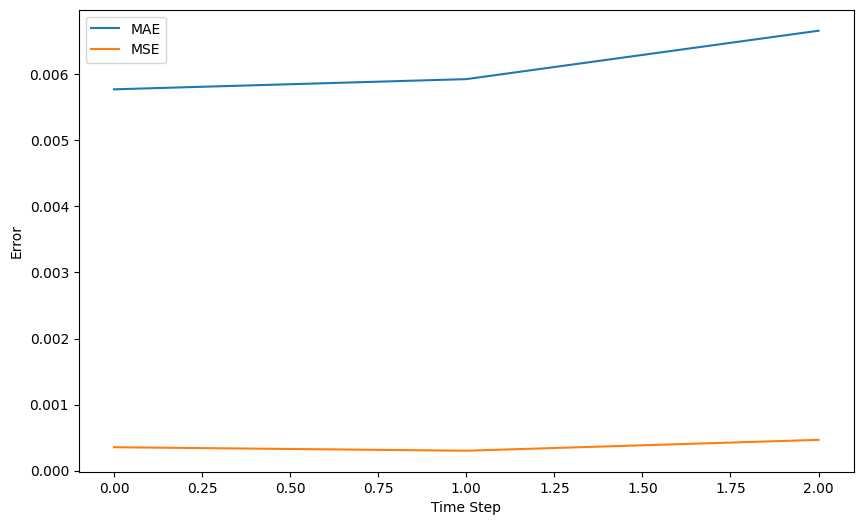

In [ ]:
# MAE와 MSE 값 계산
mae = np.mean(np.abs(y_test - y_pred), axis=0)
mse = np.mean(np.square(y_test - y_pred), axis=0)

# 그래프 그리기
plt.figure(figsize=(10,6))
plt.plot(mae, label='MAE')
plt.plot(mse, label='MSE')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.legend()
plt.show()

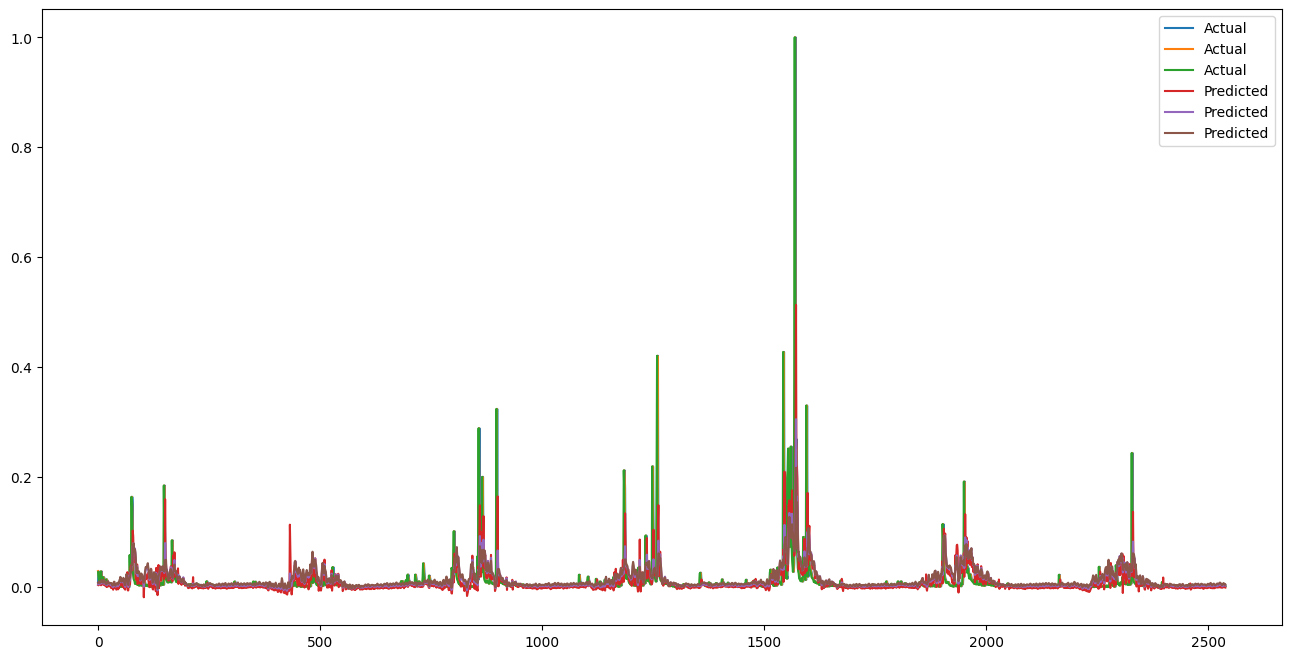

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()